In [1]:

scriptdirectory = r"C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Tübingen_Branch"
inputdirectory = r"D:\Files_Reutlingen_Jenny\19-04-16\190416_h5"

output_directory = r"D:\Files_Reutlingen_Jenny\19-04-16\190416_paper\analysis_01_HCx_GFP_B_aCSF_base"
filename = "01_HCx_GFP_B_aCSF_base"




In [2]:


import os
os.chdir(scriptdirectory)




import sys
import numpy as np
import pandas as pd
import importlib

import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from Butterworth_Filter import butter_bandpass, butter_bandpass_filter

import glob
from plot_signal_and_spikes import plot_signal_and_spikes_from_bandpassfilteredsignal
import time

from neo.core import AnalogSignal
import quantities as pq

from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd
import pickle

%matplotlib notebook


In [18]:
'''

FUNCTIONS

'''


def get_channel_infos(filedirectory, meafile):
    channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirectory, 
                                                          meafile))
    print(channel_raw_data.recordings)
    print(channel_raw_data.comment)
    print(channel_raw_data.date)
    print(channel_raw_data.clr_date)
    print(channel_raw_data.date_in_clr_ticks)
    print(channel_raw_data.file_guid)
    print(channel_raw_data.mea_name)
    print(channel_raw_data.mea_sn)
    print(channel_raw_data.mea_layout)
    print(channel_raw_data.program_name)
    print(channel_raw_data.program_version)
    analognumber = len(channel_raw_data.recordings[0].analog_streams.keys())
    print('In total '+ str(analognumber) 
          + " analog_streams were identified.\n")
    for i in range(len(channel_raw_data.recordings[0].analog_streams.keys())):
        keylist = []
        stream = channel_raw_data.recordings[0].analog_streams[i]
        for key in stream.channel_infos.keys():
                keylist.append(key)
        channel_id = keylist[0]
        datapoints = channel_raw_data.recordings[0].analog_streams[i].channel_data.shape[1]
        samplingfrequency = stream.channel_infos[channel_id].sampling_frequency
        ticks = stream.channel_infos[channel_id].info['Tick']
        time = stream.get_channel_sample_timestamps(channel_id)
        scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
        time_in_sec = time[0] * scale_factor_for_second
        timelengthrecording_ms = time[0][-1]+ticks
        timelengthrecording_s = (time[0][-1]+ticks)*scale_factor_for_second
        print("analog_stream Nr. " + str(i) + ": ")
        print("datapoints measured = " + str(datapoints))
        print("sampling frequency = " + str(samplingfrequency))
        print("ticks = " + str(ticks))
        print("total recordingtime is: " 
              + str(timelengthrecording_s) + "seconds \n")




def get_MEA_Signal(analog_stream, channel_idx, from_in_s=0, to_in_s=None):
    '''
    Extracts one Channels (channel_idx) Sginal 
    
    :param analog_stream = the analogstream from one recording
    :param channel_idx   = the channel index of the channel where you 
                            extract the values from
    :param from_in_s     = starting point of the range you want to observe 
                            in seconds
    :param to_in_s       = ending point of the range you want to observe. 
                            Default is None (i.e. whole range)
    
    Returns: the signal in uV, time stamps in sec, the sampling frequency
    
    
    '''
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude

    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(
            analog_stream.channel_data.shape[1], 
            int(to_in_s * sampling_frequency)
            )

    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(
        channel_id, from_idx, to_idx
        )

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second

    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV
    
    return signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second


def get_MEA_Channel_labels(np_analog_for_filter):
    '''
    Gives a List of all MEA Channel Labels (e.g. R12) in the order they appear
    within the recording.
    
    :param analogstream_data = an numpy array shape(channels, data)
    
    '''
    labellist = []
    for i in range(0, len(np_analog_for_filter)):
        #channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[i]
        channel_info = analog_stream_0.channel_infos[channel_id]
        #print(channel_info.info['Label'])
        labellist.append(channel_info.info['Label'])
    return labellist
    

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return 
    them as an array

    The signal transitions from a sample above the threshold to a sample 
    below the threshold for a detection and
    the last detection has to be more than dead_time apart 
    from the current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff(
        (signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(
        np.diff(threshold_crossings) >= dead_time_idx, 0, True
        )
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(
            np.diff(threshold_crossings) >= dead_time_idx, 0, True
            )
    return threshold_crossings


def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx


def align_to_minimum(signal, fs, threshold_crossings, search_range, first_time_stamp=0):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal 
                                crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the 
                         minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)


def find_triggers(dset_trigger, tick):
    
    for i in range(0,len(dset_trigger)-1):
        trigger_n=i
        Trigger_An=dset_trigger[trigger_n]
        diff_An=np.diff(Trigger_An)
        peaks, _ = find_peaks(diff_An, height = 2000) #MEA60=0.75
        peaks_off, _ = find_peaks(-diff_An, height = 2000) #""
        if len(peaks)>=0:
            break
    
    if trigger_n ==0:
        odd_peaks= peaks
        odd_peaks_off= peaks_off
    else:
        odd_peaks=peaks
        odd_peaks_off=peaks_off
    #x=np.arange(len(Trigger_An))*tick
    #plt.plot(x, Trigger_An)
    return odd_peaks, odd_peaks_off, diff_An

def spike_on_off(trigger_on, trigger_off, spikedic, tick):
    """
    Takes the dictionary with all spikes and sorts them into either a dictionary for
    spikes while trigger on (=ONdic) or off (=OFFdic)
    
    :param trigger_on =basically created through the find_triggers function 
                        and marks points were stimulation is turned on
    :param trigger_off =see trigger_on but for stimulation off
    :spikedic = dictionary of spikes for each electrode
    :tick
    """
    on=[]
    off=[]
    ONdic ={}
    OFFdic={}
    Trigger_An=[]
    Trigger_Aus=[]
    
    if len(trigger_off)==0:
        Trigger_An=[]
    elif trigger_off[len(trigger_off)-1]>trigger_on[len(trigger_on)-1]:
        Trigger_An=trigger_on*tick
    else:
        Trigger_An=[]
        for n in range(0,len(trigger_on)-1):
            Trigger_An.append(trigger_on[n]*tick)   
        Trigger_An=np.array(Trigger_An)

            
    if len(trigger_on)==0:
        Trigger_Aus=[]
    elif trigger_off[0]>trigger_on[0]:
        Trigger_Aus=trigger_off*tick
    else:
        Trigger_Aus=[]
        for n in range(1,len(trigger_off)):
            Trigger_Aus.append(trigger_off[n]*tick)
        Trigger_Aus=np.array(Trigger_Aus)
    
    Trigger_Aus2=np.insert(Trigger_Aus,0,0)
    
    for key in spikedic:
        ON = []
        OFF = []
        for i in spikedic[key]: #i mit 40 multiplizieren, da Trigger an und aus mit Tick multipliziert sind
            if len(Trigger_An)==0:
                OFF.append(i)
            if any(Trigger_An[foo] < i*tick < Trigger_Aus[foo]  for foo in np.arange(len(Trigger_Aus)-1)):
                ON.append(i)
            elif any(Trigger_Aus2[foo]  < i*tick < Trigger_An[foo]  for foo in np.arange(len(Trigger_An))):
                OFF.append(i)
        ONdic[key]=np.asarray(ON)
        OFFdic[key]=np.asarray(OFF)
    
    return ONdic, OFFdic


def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[int((index-pre_idx)):int((index+post_idx))]
            cutouts.append(cutout)
    if len(cutouts)>0:
        return np.stack(cutouts)
    
    
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts

    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))

    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')

    if show:
        plt.show()

        
def butter_lowpass_filter(data, cutoff, fs, order):

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def get_next_maximum(signal, index, max_samples_to_search):
    """
    Returns the index of the next maximum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    max_idx = np.argmax(signal[index:search_end_idx])
    return index + max_idx



def lfp_crossing_detection(lowpass_filtered_signal, lfp_threshold, minimal_length = 0.05):
    
    '''
    parameters 
    
    lowpass_filtered_signal : array like / list
        the lowpass filtered signal which is considered as the LFP
    
    lfp_threshold : float / int
        the threshold when there is a crossing we regard it as LFP
        deviation
        
    minimal_length : float
        minimal length of a LFP deviation to be considered relevant,
        default is 50ms
        the value is given in seconds
        
    _________
    
    returns:
    
    lfp_down_crossing : dict
        k = channellabel
        v = list of tuples (a,b) with a start of a deviation, b stop in seconds
        
    lfp_up_crossing : dict
        analogue to lfp_down_crossing
        
    amplitudes_down : list
        every down crossing has its local minimum which is the maximal negative amplitude
    
    
    amplitudes_down : list
        every up crossing has its local minimum which is the maximal negative amplitude
    
    '''

    # dicts will have tuples with a start and stop of the lfp crossing
    lfp_up_crossing = []
    lfp_down_crossing = []
    amplitudes_up = []
    amplitudes_down = []
    
    # lfp crosses below threshold
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] < -lfp_threshold) and (lowpass_filtered_signal[i-1] >= -lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] < -lfp_threshold:
                stop = i
                i += 1
            # filter for at least 50ms  of LFP deviation
            start_seconds = start*scale_factor_for_second*tick 
            stop_seconds = stop*scale_factor_for_second*tick
            difference_seconds = stop_seconds - start_seconds
            if difference_seconds >= 0.05: # in seconds --> 50 ms
            
                lfp_down_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
                amplitude_point = get_next_minimum(lowpass_filtered_signal, start, stop-start)
                amplitude_down = lowpass_filtered_signal[amplitude_point]
                amplitudes_down.append(amplitude_down)
            
    # lfp crosses above threshold
    
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] > lfp_threshold) and (lowpass_filtered_signal[i-1] <= lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] > lfp_threshold:
                stop = i
                i += 1
            # filter for at least 50ms  of LFP deviation
            start_seconds = start*scale_factor_for_second*tick 
            stop_seconds = stop*scale_factor_for_second*tick
            difference_seconds = stop_seconds - start_seconds
            if difference_seconds >= 0.05: # in seconds --> 50 ms
            
                lfp_up_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
                amplitude_point = get_next_maximum(lowpass_filtered_signal, start, stop-start)
                amplitude_up = lowpass_filtered_signal[amplitude_point]
                amplitudes_up.append(amplitude_up)


    return lfp_down_crossing, lfp_up_crossing, amplitudes_down, amplitudes_up



In [5]:
# set filter cuts in Hz
lowcut = 150
highcut = 4500

# Length of cutouts around shapes
pre = 0.001 # 1 ms
post= 0.002 # 2 ms


# get filelist
os.chdir(inputdirectory)
filelist= glob.glob("*.h5")


resting_spikedic={}
spikedic={}
spikedic_MAD={}
artefactsdic_MAD={}
cutouts_dic ={} 
keylist = []            



    

In [6]:
filelist

['01_HCx_GFP_B_aCSF_base.h5',
 '02_HCx_GFP_B_hCSF.h5',
 '03_HCx_GFP_B_aCSF_post.h5',
 '04_HCx_GFP_B_aCSF_highK.h5',
 'HCx_GFP_B_aCSF_1000on10soff.h5',
 'HCx_GFP_B_aCSF_10hz_20on80off_60s.h5',
 'HCx_GFP_B_aCSF_10hz_50on50off_60s.h5',
 'HCx_GFP_B_aCSF_20hz_30on20off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_10on10off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_1on19off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_5on15off_1s.h5']

In [7]:
filename = filelist[5]

In [8]:
filedatebase = filename.split('T')[0]
filenamebase = filename.split('.h5')[0]
filebase = filedatebase + '_' + filenamebase
print('Working on file: ' +filename)
channel_raw_data = McsPy.McsData.RawData(filename)
get_channel_infos(inputdirectory, filename)


analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
stream = analog_stream_0
for key in stream.channel_infos.keys():
    keylist.append(key)

Working on file: HCx_GFP_B_aCSF_10hz_20on80off_60s.h5
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
{0: <Recording label=, AnalogStreams=2, duration_time=-636910243924124374 microsecond>}

2019-04-16 15:13:33.692440
Dienstag, 16. April 2019
636910244136924374
00000000-0000-0000-0000-000000000000
256MEA100/30iR

256MEA100_30_iR
MC_Rack
4.5.3.0
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 5320000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 5320000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">
In total 2 analog_streams were ide

In [9]:
channel_id = keylist[0]
tick = stream.channel_infos[channel_id].info['Tick']
time = stream.get_channel_sample_timestamps(channel_id)
first_recording_timepoint = time[0][0]
scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
time_in_sec = time[0]*scale_factor_for_second
timelengthrecording_ms = time[0][-1]+tick
timelengthrecording_s = (time[0][-1]+tick)*scale_factor_for_second
fs = int(stream.channel_infos[channel_id].sampling_frequency.magnitude)


analog_stream_0_data = analog_stream_0.channel_data
np_analog_stream_0_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )

# the data is now transposed
np_analog_for_filter = np.transpose(np_analog_stream_0_data)
np_analog_stream_1_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
np_analog_stream_1_data_transpose = np.transpose(np_analog_stream_1_data)


# choose the correct channel you want to plot
labellist = get_MEA_Channel_labels(np_analog_for_filter)

# make a dictionary so we can reverse search
label_number_dic = {}
for i in range(0, len(labellist)):
    channel_label = labellist[i]
    label_number_dic[channel_label] = i
    

In [11]:
bandpass_dic={}
lowpass_dic={}

In [12]:
#for i in range (0, len(np_analog_for_filter)):
for i in range(0, 1):
    # for every channel we get the signal, filter it, define a threshold
    # see the crossings, align them to the next minimum (=spikes)
    # fill the dictionary with the tickpoints
    # and finally plot everything
    channel_idx = i
    channellabel = labellist[channel_idx]
    labellist = get_MEA_Channel_labels(np_analog_for_filter)
    signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, channel_idx)
    #bandpassfilteredsignal = butter_bandpass_filter(
     #   signal_in_uV, lowcut, highcut, sampling_frequency
      #  )
    
    # get the lowpass signal
    # Filter requirements.
    T = timelengthrecording_s         # Sample Period
    fs = fs      # sample rate, Hz
    cutoff = 100      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    
    butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)
    
    #bandpass_dic[channellabel] = bandpassfilteredsignal
    lowpass_dic[channellabel] = butter_lowpass_filtered_signal

In [13]:
lowpass_dic

{'R12': array([ 2.38618679,  2.36352728,  2.34067946, ..., -0.64169955,
        -0.64179409, -0.64186282])}

In [14]:
blfs = lowpass_dic['R12']

In [33]:
lfp_std = np.std(blfs)
threshold_LFP = lfp_std * 3

In [35]:
down_cross, up_cross, amp_down, amp_up = lfp_crossing_detection(blfs, threshold_LFP)


<IPython.core.display.Javascript object>


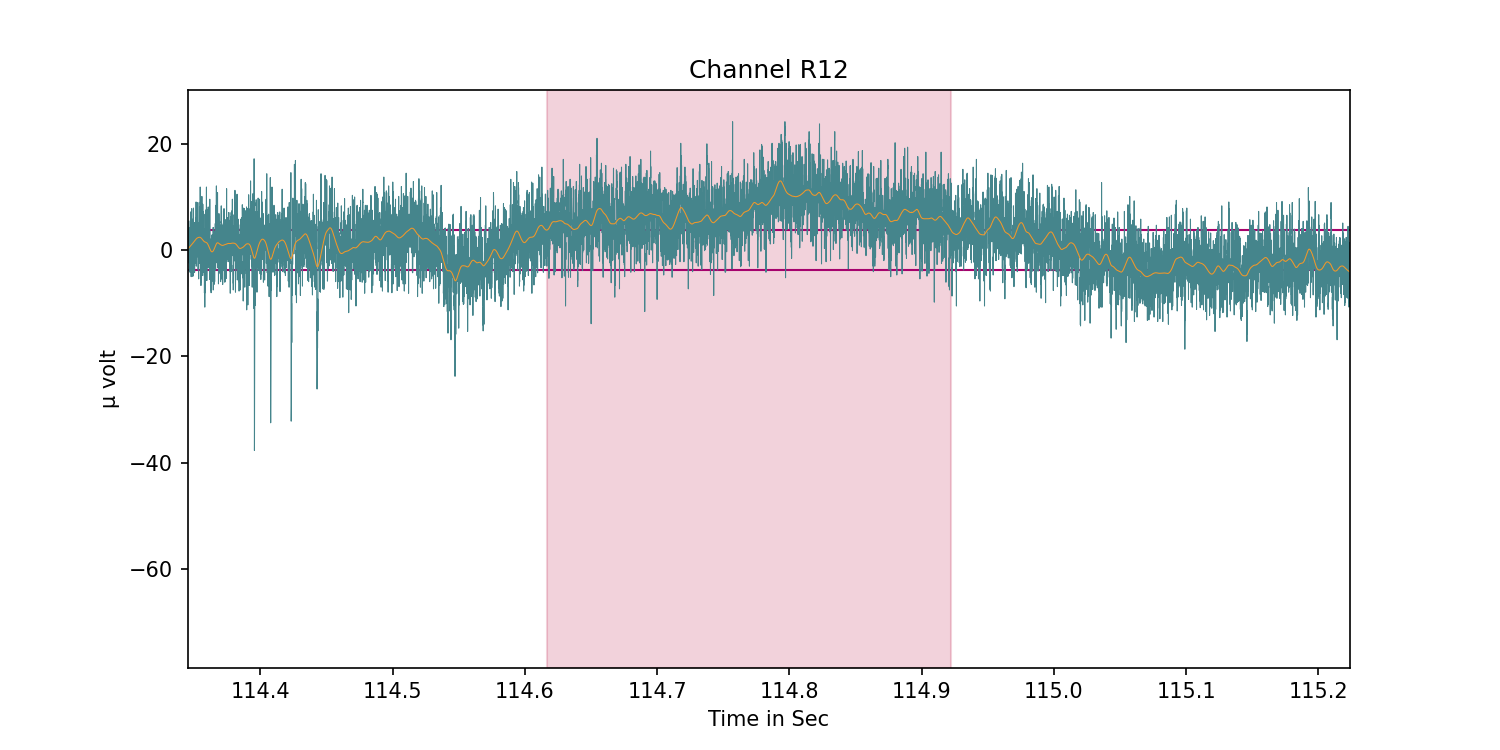

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.1)
#ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
#ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [threshold_LFP, threshold_LFP], c="#A6036D", lw=1)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [-threshold_LFP, -threshold_LFP], c="#A6036D", lw=1)
ax = plt.plot(time_in_sec, signal_in_uV, c='#45858C', linewidth=0.5)
ax = plt.plot(time_in_sec, blfs, c='#F29829', linewidth=0.5)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec')
ax = plt.ylabel('µ volt')


<IPython.core.display.Javascript object>


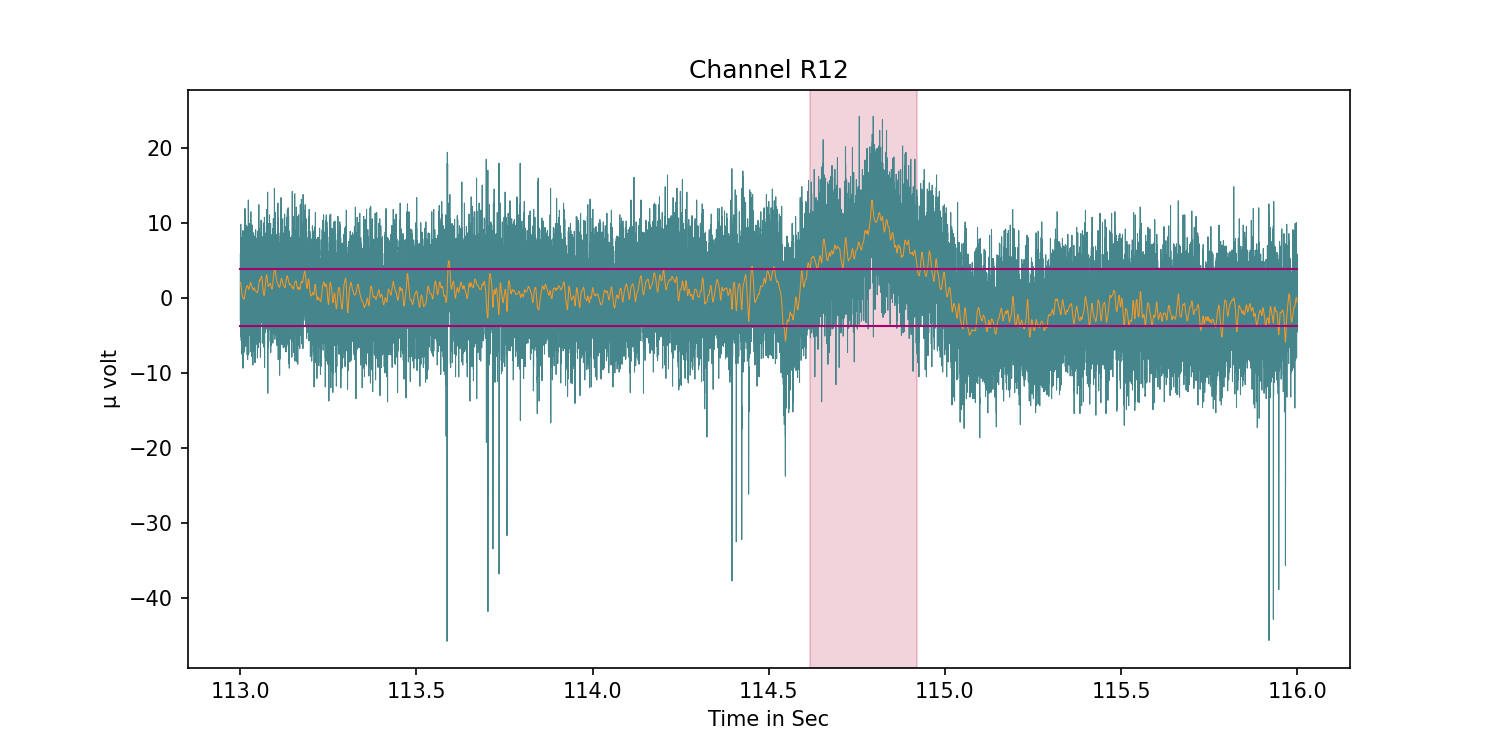

In [60]:
for i in up_cross:
    start = i[0]
    stop = i[1]
    start_ind = list(time_in_sec).index(int(start))
    stop_ind = list(time_in_sec).index(int(np.ceil((stop))))
    
    
    diff = stop_ind - start_ind
    plotstart_ind = start_ind - diff
    plotstop_ind = stop_ind + diff
    
    
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    #ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.1)
    #ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
    #ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
    ax = plt.plot(time_in_sec[plotstart_ind:plotstop_ind], signal_in_uV[plotstart_ind:plotstop_ind], c='#45858C', linewidth=0.5)
    ax = plt.plot(time_in_sec[plotstart_ind:plotstop_ind], blfs[plotstart_ind:plotstop_ind], c='#F29829', linewidth=0.5)
    ax = plt.plot([time_in_sec[plotstart_ind], time_in_sec[plotstop_ind]], [threshold_LFP, threshold_LFP], c="#A6036D", lw=1)
    ax = plt.plot([time_in_sec[plotstart_ind], time_in_sec[plotstop_ind]], [-threshold_LFP, -threshold_LFP], c="#A6036D", lw=1)
    
    for i in down_cross:
        ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
    for i in up_cross:
        ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

    ax = plt.title('Channel %s' %channellabel)
    ax = plt.xlabel('Time in Sec')
    ax = plt.ylabel('µ volt')

In [56]:
int(start), np.ceil(stop)

(114, 115.0)

In [37]:
time_in_sec

array([0.0000000e+00, 4.0000000e-05, 8.0000000e-05, ..., 2.1279988e+02,
       2.1279992e+02, 2.1279996e+02])

In [41]:
list(time_in_sec).index(up_cross[0][1])

ValueError: 114.92212 is not in list